True

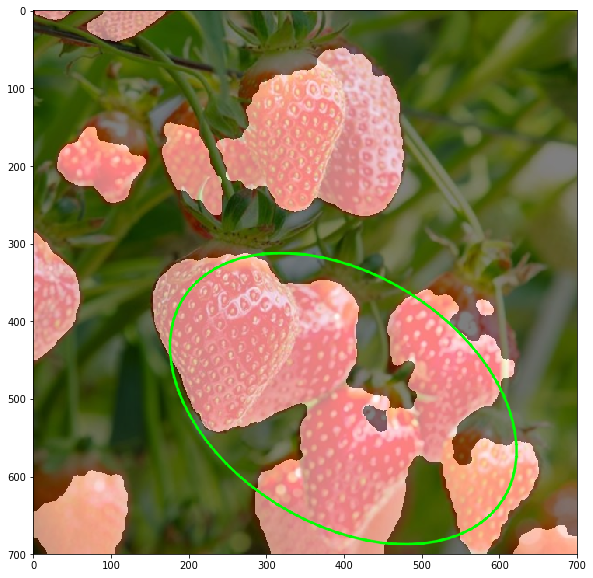

In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from math import cos, sin
#from __future__ import division

green = (0, 255, 0)
def show(image):
    # figure size in inches
    plt.figure(figsize = (10,10))
    plt.imshow(image, interpolation = 'nearest')

def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    return img

def find_biggest_contour(image):
    # copy image
    image = image.copy()
    contours, hierachy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # isolating the largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    
    return biggest_contour, mask

def circle_contour(image, contour):
    #bounding ellipse
    image_with_ellipse = image.copy()
    ellipse = cv2.fitEllipse(contour)
    cv2.ellipse(image_with_ellipse, ellipse, green, 2, cv2.LINE_AA)
    return image_with_ellipse
    
def find_strawberry(image):
    # convert to the color scheme blue green red
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # scale our image properly
    max_dimension = max(image.shape)
    scale = 700/max_dimension
    image = cv2.resize(image, None, fx=scale, fy=scale)
    # clean our image, elimiate noise
    image_blur = cv2.GaussianBlur(image, (7, 7), 0)
    image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)
    
    # define filter
    # filter by the color, intensity
    min_red = np.array([0, 100, 80])
    max_red = np.array([10, 256, 256])
    mask1 = cv2.inRange(image_blur_hsv,  min_red, max_red)
    # filter by brightness
    min_red2 = np.array([170, 100, 80])
    max_red2 = np.array([180, 256, 256])
    mask2 = cv2.inRange(image_blur_hsv, min_red2, max_red2)
    
    # combine our masks
    mask = mask1 + mask2
    #segmentation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)
    
    # find the biggest strawberry
    big_strawberry_contour, mask_strawberries = find_biggest_contour(mask_clean)
    # overlay
    overlay = overlay_mask(mask_clean, image)
    
    # circle the biggest strawberry
    circled = circle_contour(overlay, big_strawberry_contour)
    
    show(circled)
    
    # convert back to original color scheme
    bgr = cv2.cvtColor(circled, cv2.COLOR_RGB2BGR)
    
    return bgr
    
# read the image
image = cv2.imread('img1.jpeg')
result = find_strawberry(image)
cv2.imwrite('imgn1.jpg', result)
    